# Minggu 2 — Data & EDA

## Isi Singkat
1. Apa itu data? (glosarium + analogi)
2. Muat dataset Iris (tabel kecil yang mudah)
3. EDA: cek bentuk, missing, distribusi numerik, kategori, proporsi label
4. Split data yang benar (stratified)
5. Pipeline praproses (imputation → encoding → scaling)
6. Latih model baseline
7. Evaluasi (classification report + confusion matrix)
8. Uji coba prediksi dengan input teks
9. Etika & privasi data (singkat)
10. Tugas M2 (instruksi jelas) + self-check + ekspor catatan

## 1) Apa itu Data? 
- **Data**: catatan fakta yang bisa dibaca komputer. Ibarat **bahan masak**.
- **Record/Baris**: satu contoh data. Ibarat **satu buah**.
- **Feature/Kolom**: sifat dari data (angka/kategori/teks). Ibarat **manis, ukuran, warna**.
- **Label/Target**: jawaban yang mau diprediksi (kelas). Ibarat **jenis buah**.

**Klasifikasi** = menebak **kategori**. **Regresi** = menebak **angka**.

Di notebook ini kita pakai **dataset Iris**: panjang/lebar sepal & petal → prediksi **jenis bunga**.

## 2) Muat Dataset Iris (Tabular)
Kita pakai data klasik **Iris** (kecil, mudah). Kita juga buat satu kolom kategori tambahan (`size`) supaya kamu melihat **encoding** kategori.

In [1]:
import numpy as np, pandas as pd
from sklearn.datasets import load_iris
np.random.seed(42)

iris = load_iris(as_frame=True)
df = iris.frame.copy()
df.columns = ['sepal_length','sepal_width','petal_length','petal_width','label']

# Tambah kolom kategori sederhana dari petal_length (small/medium/large)
df['size'] = pd.cut(df['petal_length'], bins=[-1,2,5,10], labels=['small','medium','large'])

# Buat beberapa nilai hilang (missing) agar kita bisa praktik imputation
rng = np.random.default_rng(7)
miss_idx = rng.choice(df.index, size=10, replace=False)
df.loc[miss_idx[:6], 'sepal_width'] = np.nan
df.loc[miss_idx[6:], 'size'] = np.nan

df.head()

,sepal_length,sepal_width,petal_length,petal_width,label,size
0,5.1,3.5,1.4,0.2,0,small
1,4.9,3.0,1.4,0.2,0,small
2,4.7,3.2,1.3,0.2,0,small
3,4.6,3.1,1.5,0.2,0,small
4,5.0,3.6,1.4,0.2,0,small


## 3) EDA — Langkah 1: Bentuk & Tipe Kolom
Kita lihat ukuran tabel (baris × kolom) dan tipe data tiap kolom.

In [2]:
print('Bentuk data (rows, cols):', df.shape)
print('\nTipe kolom:')
print(df.dtypes)

Bentuk data (rows, cols): (150, 6)

Tipe kolom:
sepal_length     float64
sepal_width      float64
petal_length     float64
petal_width      float64
label              int64
size            category
dtype: object


## 4) EDA — Langkah 2: Missing (Nilai Hilang)
Kita hitung **persentase missing** per kolom. Ini penting agar kita tahu kolom mana yang perlu **imputation**.

In [3]:
missing_rate = df.isna().mean().round(3)
print('Missing rate per kolom:')
print(missing_rate)

Missing rate per kolom:
sepal_length    0.000
sepal_width     0.040
petal_length    0.000
petal_width     0.000
label           0.000
size            0.027
dtype: float64


## 5) EDA — Langkah 3: Distribusi Numerik
Kita lihat ringkasan statistik dan **histogram** untuk fitur numerik. Grafik membantu kita melihat sebaran nilai.

,count,mean,std,min,25%,50%,75%,max
sepal_length,150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal_width,144.0,3.066667,0.440756,2.0,2.8,3.00,3.4,4.4
petal_length,150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal_width,150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5


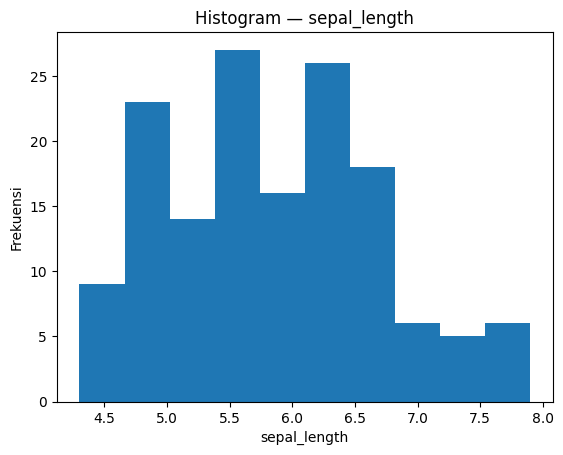

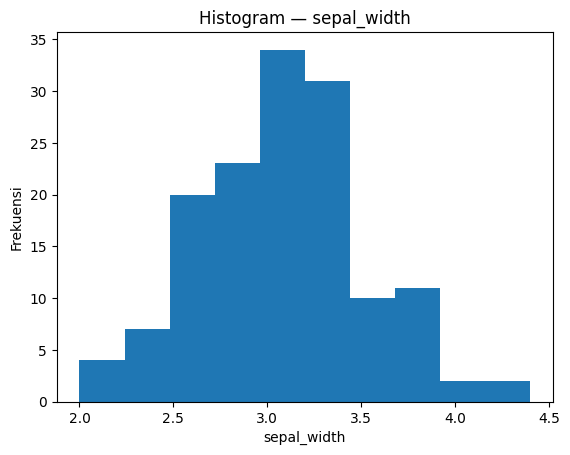

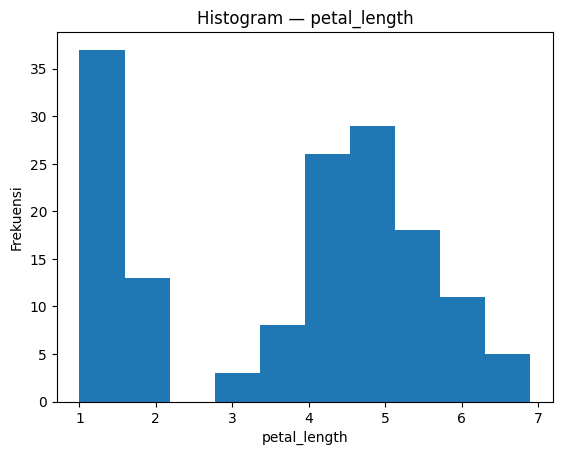

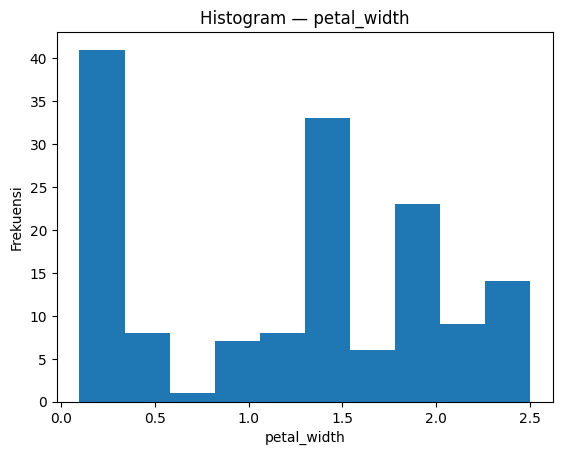

In [4]:
num_cols_all = ['sepal_length','sepal_width','petal_length','petal_width']
display(df[num_cols_all].describe().T)

import matplotlib.pyplot as plt
for col in num_cols_all:
    fig = plt.figure()
    plt.hist(df[col].dropna())
    plt.title(f'Histogram — {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')
    plt.show()

## 6) EDA — Langkah 4: Distribusi Kategori (`size`)
Kolom `size` adalah **kategori**. Kita lihat frekuensinya.

size
medium    57
small     48
large     41
NaN        4
Name: count, dtype: int64


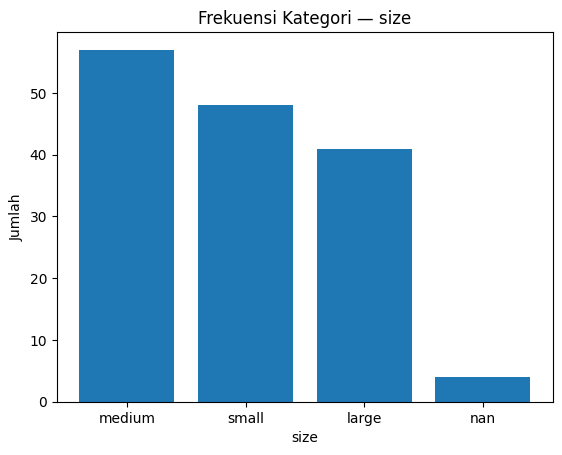

In [5]:
print(df['size'].value_counts(dropna=False))

# Grafik batang sederhana untuk kategori
counts = df['size'].value_counts(dropna=False)
fig = plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title('Frekuensi Kategori — size')
plt.xlabel('size')
plt.ylabel('Jumlah')
plt.show()

## 7) EDA — Langkah 5: Proporsi Label (Keseimbangan Kelas)
Kita cek apakah jumlah tiap kelas label seimbang. Untuk klasifikasi, ini penting untuk **stratified split**.

In [6]:
print('Jumlah per label (0=setosa, 1=versicolor, 2=virginica):')
print(df['label'].value_counts())
print('\nProporsi per label:')
print(df['label'].value_counts(normalize=True).round(3))

Jumlah per label (0=setosa, 1=versicolor, 2=virginica):
label
0    50
1    50
2    50
Name: count, dtype: int64

Proporsi per label:
label
0    0.333
1    0.333
2    0.333
Name: proportion, dtype: float64


## 8) Split Data yang Benar (Stratified)
**Kenapa split dulu?** Agar evaluasi adil. **Stratified** menjaga proporsi kelas sama di train & test.
**Anti-leakage**: jangan fit scaler/encoder pada seluruh data. Fit hanya di **train**.

In [7]:
from sklearn.model_selection import train_test_split

num_cols = ['sepal_length','sepal_width','petal_length','petal_width']
cat_cols = ['size']

X = df[num_cols + cat_cols]
y = df['label']

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_tr.shape, ' Test shape:', X_te.shape)

Train shape: (120, 5)  Test shape: (30, 5)


## 9) Pipeline Praproses (Rapi & Anti-Leakage)
Urutan minimal:
1. **Missing**: Numerik → median; Kategori → most_frequent
2. **Encoding**: Kategori → OneHotEncoder(handle_unknown='ignore')
3. **Scaling**: Numerik → StandardScaler

Kita pakai `ColumnTransformer` + `Pipeline` agar rapi dan aman dari **leakage**.

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler()),
])
cat_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols),
])

## 10) Latih Model Baseline
Kita gunakan **Logistic Regression** (model sederhana namun kuat untuk baseline).

In [9]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(max_iter=1000, random_state=42)),
])

clf.fit(X_tr, y_tr)
print('Model siap digunakan.')

Model siap digunakan.


## 11) Evaluasi Hasil (Metrik + Confusion Matrix)
- **classification_report**: ringkasan precision, recall, f1, accuracy.
- **confusion matrix**: melihat salahnya di kelas mana.

Tips baca cepat:
- **Accuracy**: % prediksi benar.
- **F1-score**: seimbangkan precision & recall (berguna jika kelas tidak seimbang).

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       0.83      1.00      0.91        10
   virginica       1.00      0.80      0.89        10

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



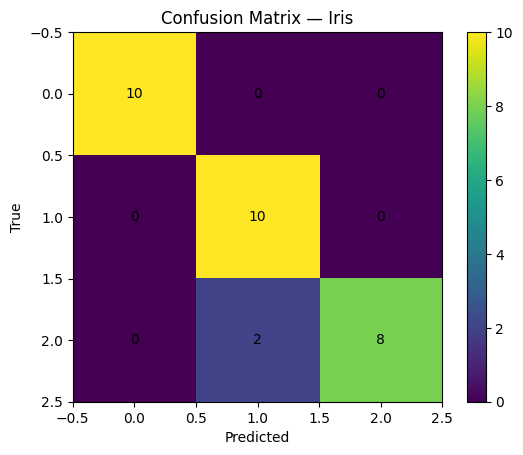

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_pr = clf.predict(X_te)
print(classification_report(y_te, y_pr, target_names=iris.target_names))

cm = confusion_matrix(y_te, y_pr)
fig = plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix — Iris')
plt.xlabel('Predicted')
plt.ylabel('True')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar()
plt.show()

## 12) Uji Coba Prediksi (Input Teks Sederhana)
Masukkan 4 angka **(cm)**: `sepal_length sepal_width petal_length petal_width`.
Format boleh: `5.1 3.5 1.4 0.2` atau `5,1 3,5 1,4 0,2` (koma desimal).

In [11]:
import re

CLASS_NAMES = list(iris.target_names)

def _to_float(num_str: str) -> float:
    s = num_str.strip()
    if re.fullmatch(r"-?\d+,\d+", s):
        s = s.replace(',', '.')
    return float(s)

def parse_numbers(text: str):
    nums = re.findall(r"-?\d+[.,]?\d*", text)
    if len(nums) < 4:
        raise ValueError('Butuh 4 angka: sepal_len sepal_wid petal_len petal_wid')
    vals = [_to_float(n) for n in nums[:4]]
    return np.array(vals, dtype=float).reshape(1, -1)

def predict_from_text(text: str):
    X_in = parse_numbers(text)
    # Perlu tambahkan kolom kategori `size` (diturunkan dari petal_length)
    petal_length = X_in[0,2]
    if petal_length < 2: size_val = 'small'
    elif petal_length < 5: size_val = 'medium'
    else: size_val = 'large'
    # susun DataFrame dengan kolom yang sama seperti training
    df_in = pd.DataFrame({
        'sepal_length':[X_in[0,0]],
        'sepal_width':[X_in[0,1]],
        'petal_length':[X_in[0,2]],
        'petal_width':[X_in[0,3]],
        'size':[size_val]
    })
    proba = clf.predict_proba(df_in)[0]
    pred_idx = int(np.argmax(proba))
    pred_name = CLASS_NAMES[pred_idx]
    top = sorted([(CLASS_NAMES[i], float(p)) for i,p in enumerate(proba)], key=lambda x: x[1], reverse=True)
    return pred_name, top, df_in.iloc[0].to_dict()

# Contoh pemakaian
examples = ['5.1 3.5 1.4 0.2', '6.0 2.9 4.5 1.5', '6,3 3,3 6,0 2,5']
for ex in examples:
    name, topk, feat = predict_from_text(ex)
    print(f"\nInput: {ex}")
    print('Fitur dipakai:', feat)
    print('Prediksi:', name)
    print('Keyakinan:')
    for cls, p in topk:
        print(f"  - {cls:10s}: {p*100:5.2f}%")


Input: 5.1 3.5 1.4 0.2
Fitur dipakai: {'sepal_length': 5.1, 'sepal_width': 3.5, 'petal_length': 1.4, 'petal_width': 0.2, 'size': 'small'}
Prediksi: setosa
Keyakinan:
  - setosa    : 98.79%
  - versicolor:  1.21%
  - virginica :  0.00%

Input: 6.0 2.9 4.5 1.5
Fitur dipakai: {'sepal_length': 6.0, 'sepal_width': 2.9, 'petal_length': 4.5, 'petal_width': 1.5, 'size': 'medium'}
Prediksi: versicolor
Keyakinan:
  - versicolor: 81.99%
  - virginica : 16.77%
  - setosa    :  1.24%

Input: 6,3 3,3 6,0 2,5
Fitur dipakai: {'sepal_length': 6.3, 'sepal_width': 3.3, 'petal_length': 6.0, 'petal_width': 2.5, 'size': 'large'}
Prediksi: virginica
Keyakinan:
  - virginica : 99.44%
  - versicolor:  0.55%
  - setosa    :  0.02%


## 13) Etika & Privasi (Singkat)
- Gunakan data **seperlunya** (minimisasi). Jangan unggah **PII** tanpa dasar.
- Jelaskan batasan model (bisa salah). Simpan jejak perubahan (audit trail).
- Jika ada data tanggal/waktu, hormati urutan (hindari **leakage masa depan**).

## 14) Tugas M2 — Instruksi Jelas
**Tujuan**: Satu notebook berisi **EDA → split → pipeline (missing, encoding, scaling) → baseline + metrik**.

**Langkah (urut):**
1) Jelaskan masalah dan **label** (1 kalimat).  
2) Muat data (boleh Iris/CSV kalian) + tampilkan shape, dtypes, 5 baris.  
3) Jawab **5 pertanyaan EDA** (bullet): bentuk/tipe, missing, distribusi, proporsi label, kelayakan fitur.  
4) Definisikan `num_cols` dan `cat_cols`.  
5) **Split** dengan benar (stratified / time-aware).  
6) Bangun **pipeline praproses** (impute→encode→scale).  
7) Latih **model baseline** (LogReg / Tree / RF).  
8) Tampilkan **metrik** (classification_report + confusion matrix).  
9) Tulis **3–5 catatan perbaikan** (apa yang akan kamu perbaiki minggu depan).  

**Checklist:**
- [ ] EDA 5 poin + keputusan praproses  
- [ ] Split benar + alasan  
- [ ] Pipeline jalan (tanpa leakage)  
- [ ] Metrik + confusion matrix  
- [ ] 3 contoh error & 3 ide perbaikan  

**Penamaan file**: `M2_EDA_<Nama>_<Dataset>.ipynb`. **Submit** link Colab/Drive/GitHub yang bisa dibuka.

## 15) Self-Check (Otomatis, opsional)
Jalankan sel berikut. Kalau ada yang **False**, naik lagi ke atas dan lengkapi langkah yang kurang.

In [12]:
check = {}
try:
    _ = df.head(1)
    check['df_ada'] = True
except Exception:
    check['df_ada'] = False

try:
    check['num_cols_ok'] = isinstance(num_cols, list) and len(num_cols) > 0
    check['cat_cols_ok'] = isinstance(cat_cols, list)
except Exception:
    check['num_cols_ok'] = False
    check['cat_cols_ok'] = False

try:
    from sklearn.pipeline import Pipeline
    from sklearn.compose import ColumnTransformer
    check['clf_pipeline'] = isinstance(clf, Pipeline)
    pre = clf.named_steps.get('preprocess', None)
    check['ada_preprocess'] = isinstance(pre, ColumnTransformer)
except Exception:
    check['clf_pipeline'] = False
    check['ada_preprocess'] = False

try:
    _ = y_te[:3]
    _ = y_pr[:3]
    check['ada_prediksi'] = True
except Exception:
    check['ada_prediksi'] = False

print('Ringkasan Self-check:')
for k,v in check.items():
    print(f' - {k}: {v}')

Ringkasan Self-check:
 - df_ada: True
 - num_cols_ok: True
 - cat_cols_ok: True
 - clf_pipeline: True
 - ada_preprocess: True
 - ada_prediksi: True


## 16) Ekspor Catatan EDA ke Drive (Opsional)
Tulis bullet catatanmu di variabel `eda_notes_text`, lalu jalankan sel. File akan disimpan ke `Drive/.../trpl-ai-capstone/docs/eda-notes.md`.

In [ ]:
eda_notes_text = '''
# EDA Notes (Minggu 2)
- Bentuk & tipe: ...
- Missing: ...
- Distribusi: ...
- Proporsi label: ...
- Kelayakan fitur: ...

## Keputusan praproses (3–5)
- ...
'''

import os
BASE = '/content/drive/MyDrive/trpl-ai-capstone'
os.makedirs(os.path.join(BASE, 'docs'), exist_ok=True)
path = os.path.join(BASE, 'docs', 'eda-notes.md')
with open(path, 'w') as f:
    f.write(eda_notes_text)
print('Tersimpan ke:', path)